# Task 2 - LSTM for time series classification

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import re


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
sns.set_style("darkgrid")
sns.set(font_scale=1.3)

## Data import & EDA

In [3]:
files.upload()

{}

In [4]:
FILE_NAME_PREFIX = 'Ambient_Living_'
data_file_pattern = FILE_NAME_PREFIX + r'(?P<seq_id>\d+).csv'
data_files = list(filter(lambda s: re.match(data_file_pattern, s) is not None, os.listdir()))
len(data_files)

20

In [5]:
seq_ids = sorted(int(re.match(data_file_pattern, file_name).group('seq_id')) for file_name in data_files)
seq_ids

[4, 5, 6, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]

In [0]:
def load_file(file_code, strip=False):
    df = pd.read_csv(f'{FILE_NAME_PREFIX}{file_code}.csv')
    
    if strip:
        df.columns = [c.strip() for c in df.columns]
    
    return df

### Data example

In [7]:
seq_id = seq_ids[0]
data_example = load_file(seq_id)
data_example.head()

,Sensor 1,Sensor 2,Sensor 3,Sensor 4
0,-1.00000,-0.84,0.57143,0.35
1,-0.80952,-0.40,0.19048,0.65
2,-1.00000,-0.56,0.47619,0.35
3,-0.66667,-0.16,0.71429,0.80
4,-1.00000,-0.84,0.71429,0.55


In [8]:
data_example.describe()

,Sensor 1,Sensor 2,Sensor 3,Sensor 4
count,23.000000,23.000000,23.000000,23.000000
mean,-0.720497,-0.443478,0.546584,0.436957
std,0.206723,0.213000,0.322287,0.337510
min,-1.000000,-0.840000,-0.095238,-0.350000
25%,-0.928570,-0.560000,0.261905,0.300000
50%,-0.666670,-0.400000,0.714290,0.550000
75%,-0.571430,-0.320000,0.785710,0.650000
max,-0.428570,-0.080000,0.857140,0.800000


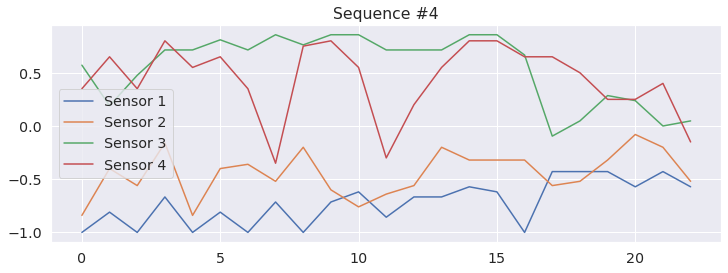

In [9]:
fig, ax = plt.subplots(figsize=(12,4))
ax = sns.lineplot(ax=ax, data=data_example, dashes=False)
_ = ax.set_title(f"Sequence #{seq_id}")

### Targets - class labels

In [10]:
# load targets (class labels) for available sequences (only those which have been uploaded)
targets = load_file('target', True).iloc[np.array(seq_ids)]
targets.head()

,#sequence_ID,class_label
4,5,1
5,6,1
6,7,1
54,55,-1
55,56,-1


In [11]:
targets['class_label'].value_counts()  # number of classes, class labels, number of examples per class

-1    11
 1     9
Name: class_label, dtype: int64

In [0]:
all_labels = ((targets['class_label'].values + 1)/2).astype("int32")

### All data files

In [0]:
# load data for the available sequences
all_data = [load_file(i) for i in seq_ids]


In [14]:
descr = targets['class_label'].to_frame()
descr.index=targets['#sequence_ID']
descr['length'] = [d.shape[0] for d in all_data]
descr['n_features'] = [d.shape[1] for d in all_data]
descr.head()

,class_label,length,n_features
#sequence_ID,,,
5,1,23,4
6,1,25,4
7,1,27,4
55,-1,21,4
56,-1,20,4


In [15]:
descr[descr.columns[1:]].describe(percentiles=np.arange(0.2, 1, 0.2))

,length,n_features
count,20.000000,20.0
mean,23.000000,4.0
std,2.339591,0.0
min,20.000000,4.0
20%,20.800000,4.0
40%,22.600000,4.0
50%,23.000000,4.0
60%,23.000000,4.0
80%,25.000000,4.0
max,27.000000,4.0


## Pre-processing
### Adjust sequence lengths to the global 80th quantile

In [16]:
q_cut = 0.8  # cut the length at the 80th quantile
q_cut_value = int(descr['length'].quantile(q_cut))  # get the length corresponding to the quantile
q_cut_value

25

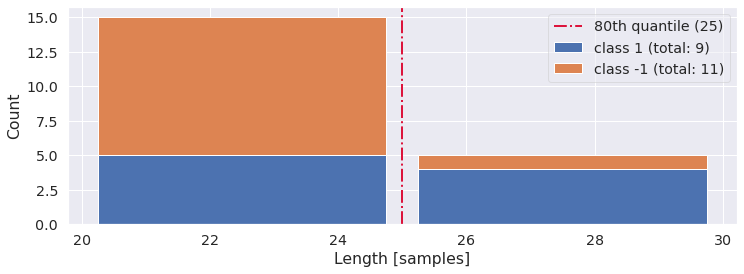

In [17]:
fig, ax = plt.subplots(figsize=(12,4))

w = 5
ln = descr['length']
labels_set = descr['class_label'].unique()
lengths_classes = [ln[descr['class_label'] == label] for label in labels_set]

hist = ax.hist(lengths_classes,
               bins=range(w*(min(ln)//w), max(ln)+w, w),
               label=[f'class {label} (total: {len(lengths_classes[i])})' for i, label in enumerate(labels_set)],
               stacked=True, rwidth=0.9)

ax.axvline(q_cut_value, color='crimson', linestyle='-.', lw=2, label=f'{100*q_cut:.0f}th quantile ({q_cut_value})')

ax.legend(fancybox=True, framealpha=0.5)
ax.set_xlabel("Length [samples]")
ax.set_ylabel("Count")
plt.show()

In [0]:
# prepare array for the pre-processed data (216x54x4)
all_data_prep = np.zeros((len(all_data), q_cut_value, all_data[0].shape[1]))

# fill the array with data for cropped sequences (the padding to 0 is automatic by non-filling the already zero-filled rows)
for i, sequence in enumerate(all_data):
    all_data_prep[i, :min(q_cut_value, sequence.shape[0]), :] = sequence.iloc[:q_cut_value, :]

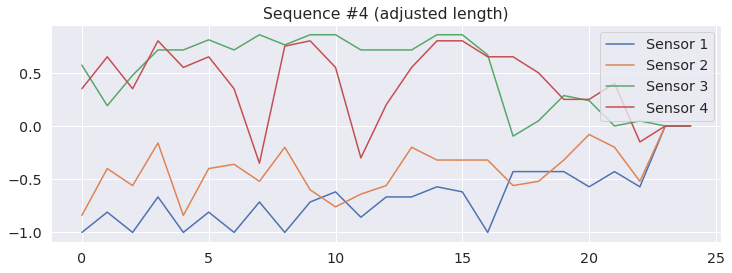

In [19]:
fig, ax = plt.subplots(figsize=(12,4))
ax = sns.lineplot(ax=ax, data=all_data_prep[0], dashes=False)
_ = ax.set_title(f"Sequence #{seq_id} (adjusted length)")
_ = ax.legend(data_example.columns)

## LSTM

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score


In [0]:
# a function defining a model to be evaluated (after wrapping by the Keras)
def make_lstm():
    lstm_model = Sequential()
    lstm_model.add(layers.LSTM(256, input_shape=all_data_prep.shape[1:]))
    lstm_model.add(layers.Dense(1, activation='sigmoid'))
    
    adam = Adam(lr=0.001)
    lstm_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return lstm_model

fit_params = dict(epochs=200, batch_size=128)


In [0]:
# define the 10-fold cross-validation split
kf = KFold(n_splits=10, shuffle=True, random_state=1)

In [0]:
# define a scoring function for the cross validation
def scorer(estimator, X, y):
    return accuracy_score((estimator.predict(X) > 0.5).astype("int32"), y) 


In [24]:
# run the cross-validation
scores = cross_val_score(KerasClassifier(make_lstm, **fit_params), X=all_data_prep, y=all_labels, cv=kf, scoring=scorer)


Epoch 1/200
1/1 [==============================] - 0s 1ms/step - loss: 0.6876 - accuracy: 0.7778
Epoch 2/200
1/1 [==============================] - 0s 1ms/step - loss: 0.6556 - accuracy: 0.7222
Epoch 3/200
1/1 [==============================] - 0s 2ms/step - loss: 0.6273 - accuracy: 0.7222
Epoch 4/200
1/1 [==============================] - 0s 1ms/step - loss: 0.6033 - accuracy: 0.7222
Epoch 5/200
1/1 [==============================] - 0s 1ms/step - loss: 0.5905 - accuracy: 0.7222
Epoch 6/200
1/1 [==============================] - 0s 1ms/step - loss: 0.5830 - accuracy: 0.7222
Epoch 7/200
1/1 [==============================] - 0s 1ms/step - loss: 0.5638 - accuracy: 0.7222
Epoch 8/200
1/1 [==============================] - 0s 2ms/step - loss: 0.5458 - accuracy: 0.7222
Epoch 9/200
1/1 [==============================] - 0s 2ms/step - loss: 0.5356 - accuracy: 0.7222
Epoch 10/200
1/1 [==============================] - 0s 2ms/step - loss: 0.5308 - accuracy: 0.7222
Epoch 11/200
1/1 [===========

In [25]:
scores

array([1. , 0.5, 0. , 0.5, 1. , 1. , 0.5, 1. , 1. , 0.5])